In [1]:
from build_Case1 import build_Case1
import numpy as np
from scipy.interpolate import interp1d
import pickle
import pandas as pd
import uuid
import time
from pathlib import Path
import io

In [2]:
rootPath = '/nobackup/jakravit/data/'
runPath = rootPath + 'HE60/run/'
batch_name = 'case1V2'
clearIOPprofiles = True
numRuns = 5

if clearIOPprofiles:
    # clear iop profiles
    %rm -rf /nobackup/jakravit/data/HE60/iop_profiles/{batch_name}
    %mkdir /nobackup/jakravit/data/HE60/iop_profiles/{batch_name}
    # clear batch files
    %rm -rf /nobackup/jakravit/data/HE60/run/batch
    %mkdir /nobackup/jakravit/data/HE60/run/batch
    # clear runlist
    %rm /nobackup/jakravit/data/HE60/run/{batch_name}_runlist.txt  
    Path('/nobackup/jakravit/data/HE60/run/{}_runlist.txt'.format(batch_name)).touch()
    # clear outputs
    %rm -rf /nobackup/jakravit/data/HE60/output/EcoLight/excel
    %mkdir /nobackup/jakravit/data/HE60/output/EcoLight/excel   
    # clear batchruns file
    %rm /nobackup/jakravit/data/HE60/run/batchruns.sh 
    with io.open(runPath + 'batchruns.sh', 'a+') as f:
        f.write('#!/bin/bash\n') 
    # clear pickles
    %rm -rf /nobackup/jakravit/data/HE60/pickles
    %mkdir /nobackup/jakravit/data/HE60/pickles 

In [3]:
# Data paths 

# phytoplankton SIOP spectral library
phyPath = rootPath+'EAP_phytoplankton_dataset/PFTs_v0817.p'
with open(phyPath, 'rb') as fp:
    phy_library = pickle.load(fp)

# NAP spectral libraries
napPath = rootPath+'EAP_NAP_dataset/NAP_v0817_or.p'
with open(napPath, 'rb') as fp:
    datanap = pickle.load(fp)  

# detpath = rootPath+'EAP_NAP_dataset/det_V1.p'
# with open(detpath, 'rb') as fp:
#     datadet = pickle.load(fp) 

# Benthic library
benthic_lib = pd.read_csv(rootPath+'benthic_spec_libary_FT_V4.csv')

# adjacency library
adj_lib = pd.read_csv(rootPath+'adjacency_spectra_V2.csv')

# aeronet library
aero_lib = pd.read_csv(rootPath+'aeronet_invdata_match.csv')

In [4]:
rows = []
uidList = []
for k in range(numRuns):
    iops, cols, row = build_Case1(phy_library, datanap, benthic_lib, adj_lib, aero_lib)
    rows.append(row)

    #% TOTAL IOPS

    # depth
    depth = iops['Depth']['Depth']
    depth = depth.reshape(-1, 1)
    xfactor = iops['Depth']['xfactor']
    dlen = len(depth)

    # chl profile
    chlProfile = [iops['Phyto']['TotChl'] * x for x in xfactor]
    chlProfile = np.asarray(chlProfile).reshape(-1, 1)
    foot = np.hstack((-1,0))
    chlzProfile = np.hstack((depth,chlProfile))
    chlzProfile = np.vstack((chlzProfile,foot))

    # absorption
    atotphy = iops['Phyto']['a_tot']
    atotmin = iops['Min']['a_tot']
    atotdet = iops['Det']['a_tot']
    atotdom = iops['CDOM']['a_tot'][63:]
    atot = atotphy + atotmin + atotdet + atotdom
    a_tot = [atot * x for x in xfactor]
    a_totphy = [atotphy * x for x in xfactor]
    a_totmin = [atotmin * x for x in xfactor]
    a_totdet = [atotdet * x for x in xfactor]
    a_totdom = [atotdom * x for x in xfactor]

    # Scatter
    btotphy = iops['Phyto']['b_tot']
    btotmin = iops['Min']['b_tot']
    btotdet = iops['Det']['b_tot']
    btot = btotphy + btotmin + btotdet
    # b_tot = [btot * x for x in xfactor]

    # attenuation
    ctotphy = atotphy + btotphy
    ctotmin = atotmin + btotmin
    ctotdet = atotdet + btotdet
    ctotdom = atotdom # no scattering
    ctot = atot + btot
    c_tot = [ctot * x for x in xfactor]
    c_totphy = [ctotphy * x for x in xfactor]
    c_totmin = [ctotmin * x for x in xfactor]
    c_totdet = [ctotdet * x for x in xfactor]
    c_totdom = [ctotdom * x for x in xfactor]

    # backscattering
    bbtotphy = iops['Phyto']['bb_tot']
    bbtotmin = iops['Min']['bb_tot']
    bbtotdet = iops['Det']['bb_tot']
    bbtot = bbtotphy + bbtotmin + bbtotdet
    bb_tot = [bbtot * x for x in xfactor]
    bb_totphy = [bbtotphy * x for x in xfactor]
    bb_totmin = [bbtotmin * x for x in xfactor]
    bb_totdet = [bbtotdet * x for x in xfactor]
    
    #% PREPARE FOR WRITING TO .TXT FILE IN HYDROLIGHT FORMAT

    # lambda
    l = np.arange(400,902.5,2.5)

    llen = len(l)
    # llen2 = str(llen)
    # l2 = [str(x) for x in l]
    line11 = np.hstack((llen,l)).reshape(1,-1)
    # AC data
    foot = np.hstack((-1,[0]*(llen*2)))
    # only phy
    acProfile_phy = np.hstack((depth,a_totphy,c_totphy))
    acProfile_phy = np.vstack((acProfile_phy,foot))
    # only min
    acProfile_min = np.hstack((depth,a_totmin,c_totmin))
    acProfile_min = np.vstack((acProfile_min,foot))
    # only det
    acProfile_det = np.hstack((depth,a_totdet,c_totdet))
    acProfile_det = np.vstack((acProfile_det,foot))
    # only dom
    acProfile_dom = np.hstack((depth,a_totdom,c_totdom))
    acProfile_dom = np.vstack((acProfile_dom,foot))
    # all components
    acProfile = np.hstack((depth,a_tot,c_tot))
    acProfile = np.vstack((acProfile,foot))  

    # bb data
    foot = np.hstack((-1,[0]*(l)))
    # only phy
    bbProfile_phy = np.hstack((depth,bb_totphy))
    bbProfile_phy = np.vstack((bbProfile_phy,foot))
    # only min
    bbProfile_min = np.hstack((depth,bb_totmin))
    bbProfile_min = np.vstack((bbProfile_min,foot))
    # only det
    bbProfile_det = np.hstack((depth,bb_totdet))
    bbProfile_det = np.vstack((bbProfile_det,foot))
    # all components
    bbProfile = np.hstack((depth,bb_tot))
    bbProfile = np.vstack((bbProfile,foot))

    #% WRITE TO TXT
    
    import string
    import random
    import os 

    iopPath = rootPath+'HE60/iop_profiles/{}/'.format(batch_name)
    if not os.path.exists(iopPath):
        os.mkdir(iopPath)
        
    def random_uid():
        alphabet = string.ascii_lowercase + string.digits
        return ''.join(random.choices(alphabet, k=10))
    uid = random_uid()
    uidList.append(uid)

    # sname.append(uid)
    iopzpath = iopPath+'{}/'.format(uid)
    if not os.path.exists(iopzpath):
        os.mkdir(iopzpath)
    # os.mkdir(rootPath + 'HE60/iop_profiles/{}/{}/'.format(batch_name,uid))
    # iopzpath = rootPath + 'HE60/iop_profiles/{}/{}/'.format(batch_name,uid)

    # acData

    # fnames
    fnames = {'total': {'acfname': 'acDatatot_' + uid + '.txt',
                        'bbfname': 'bbDatatot_' + uid + '.txt',
                        'acdata': acProfile,
                        'bbdata': bbProfile},
              'phyto': {'acfname': 'acDataphy_' + uid + '.txt',
                        'bbfname': 'bbDataphy_' + uid + '.txt',
                        'acdata': acProfile_phy,
                        'bbdata': bbProfile_phy},
              'min':   {'acfname': 'acDatamin_' + uid + '.txt',
                        'bbfname': 'bbDatamin_' + uid + '.txt',
                        'acdata': acProfile_min,
                       'bbdata': bbProfile_min},
              'det':   {'acfname': 'acDatadet_' + uid + '.txt',
                        'bbfname': 'bbDatadet_' + uid + '.txt',
                        'acdata': acProfile_det,
                        'bbdata': bbProfile_det},
              }

    # write chl data
    header = '\n'.join(['CHL CONC DATA PROFILE',
                        'SWIPE HE data files',
                        '#',
                        '#','#','#','#','#','#','#\n'])
    with open(os.path.join(iopzpath,'chlzData_{}.txt'.format(uid)),'w') as f:
        f.writelines(header)
        np.savetxt(f,chlzProfile,delimiter='\t')
    
    fmt1 = '%d,'
    fmt2 = '%1.1f,'*len(l)
    fmt3 = fmt1 +fmt2
    # write AC data
    header = '\n'.join(['TOTAL AC DATA PROFILE',
                        'SWIPE HE data files',
                        'Does not include water!',
                        '#','#','#','#','#','#','#\n'])
    for fname in fnames:
        with open(os.path.join(iopzpath,fnames[fname]['acfname']),'w') as f:
            f.writelines(header)
            np.savetxt(f,line11, fmt=fmt3, delimiter='\t') # ,fmt='%d, %1.1f'
            np.savetxt(f,fnames[fname]['acdata'],delimiter='\t')
    
    # write bb data
    header = '\n'.join(['TOTAL BB DATA PROFILE',
                        'SWIPE HE data files',
                        'Does not include water!',
                        '#','#','#','#','#','#','#\n'])
    for fname in fnames:
        with open(os.path.join(iopzpath,fnames[fname]['bbfname']),'w') as f:
            f.writelines(header)
            np.savetxt(f,line11,fmt=fmt3, delimiter='\t') # fmt='%d, %1.1f'
            np.savetxt(f,fnames[fname]['bbdata'],delimiter='\t')

    # write iroot file        
    from write_iroot import iroot
    iroot(l, iops, batch_name, uid, rootPath)
    
    # write pickle file
    with open(rootPath + 'HE60/pickles/{}.p'.format(uid), 'wb') as f:
        pickle.dump(iops,f)
            
sims = pd.DataFrame(rows,columns=cols, index=uidList)
sims.to_csv(rootPath + 'HE60/batch_data/{}_table.csv'.format(batch_name))
print ('DONE!')

DONE!


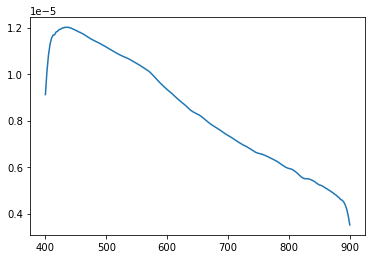

In [5]:
import matplotlib.pyplot as plt

plt.plot(l, iops['Min']['bb_tot'])

In [6]:
sims.head()

,TotChl,ph_a_tot_400.0,ph_a_tot_402.5,ph_a_tot_405.0,ph_a_tot_407.5,ph_a_tot_410.0,ph_a_tot_412.5,ph_a_tot_415.0,ph_a_tot_417.5,ph_a_tot_420.0,...,atm_Std-F,atm_VolC-C,atm_REff-C,atm_VMR-C,atm_Std-C,prof,OZA,OAA,SZA,SAA
zhwhs7lxll,2.725,0.085316,0.086761,0.087924,0.089546,0.091209,0.093078,0.094680,0.095856,0.096239,...,0.467,0.107,2.026,2.437,0.610,afglms,10,70,60,35
gsx5hmx87t,0.424,0.009628,0.009724,0.009865,0.010045,0.010213,0.010341,0.010428,0.010477,0.010492,...,0.415,0.063,2.705,3.334,0.614,afglms,25,65,60,55
rz8cw179zm,0.634,0.022181,0.022514,0.022709,0.022971,0.023195,0.023410,0.023576,0.023690,0.023702,...,0.551,0.219,1.835,2.269,0.649,afglus,35,90,40,30
7uauj2f5ar,0.264,0.010954,0.010998,0.011038,0.011104,0.011168,0.011216,0.011236,0.011236,0.011209,...,0.429,0.020,1.510,1.895,0.725,afglt,35,90,45,60
y1jlbrpol7,0.227,0.010845,0.011088,0.011257,0.011461,0.011637,0.011824,0.011981,0.012120,0.012211,...,0.378,0.035,2.755,3.471,0.642,afglt,45,90,5,40
